In [1]:
import numpy
import math
import pandas as pd
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json

seed = 7

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
additional usefull stuff:

#formating date to unix
df['date_id']=(df['Date_hour']- pd.datetime(1970,1,1)).dt.total_seconds()

#encode categforical data
dataset[:,1]=LabelEncoder().fit_transform(dataset[:,1])

# normilize features
dataset=MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset)
'''

"\nadditional usefull stuff:\n\n#formating date to unix\ndf['date_id']=(df['Date_hour']- pd.datetime(1970,1,1)).dt.total_seconds()\n\n#encode categforical data\ndataset[:,1]=LabelEncoder().fit_transform(dataset[:,1])\n\n# normilize features\ndataset=MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset)\n"

In [3]:
#data preperation
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_columns, input_dim=num_columns-1, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
	return model

def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(num_columns, input_dim=num_columns-1, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
	return model

def wider_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=num_columns-1, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
	return model

def lstm_model(input_shape):
	model = Sequential()
	model.add(LSTM(50, input_shape=input_shape))
	model.add(Dense(1))
	model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
	return model

In [13]:
# load visits data
data_file='ECE_AEZ_Visits.csv'
df = pd.read_csv(data_file)

# load test dataset of airlines
airline='international-airline-passengers.csv'
air_df = pd.read_csv(airline, usecols=[1], engine='python', skipfooter=3)

# preprocess visits data
df['Date_hour'] =  pd.to_datetime(df['Date_hour'], format='%d.%m.%Y %H:%M:%S')
df=df.sort_values(by=['Date_hour'])
df=df.loc[df['Visits'] != 0]
visits_df=df['Visits'].to_frame()

In [14]:
# scaling
scaler=MinMaxScaler(feature_range=(0, 1))

values=scaler.fit_transform(minodes_df)

In [15]:
# creating features from time series
look_back=1
values = values.tolist()
features_df=series_to_supervised(values,look_back,1)

# split into train and test sets
dataset=features_df.values


num_columns =dataset.shape[1]
print('---SHAPE:',dataset.shape)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


X_train, Y_train = train[:,:-1], train[:,-1]
X_test, Y_test = test[:,:-1], test[:,-1]

---SHAPE: (3925, 2)


In [16]:
# LSTM (+ reshaping data to 3d)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
model=lstm_model((X_train.shape[1], X_train.shape[2]))

In [25]:
# simple model
shape = (X_train.shape[1], X_train.shape[2])
model=lstm_model(shape)

In [26]:
# model summary
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
'''
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
'''

'\nestimators = []\nestimators.append((\'standardize\', StandardScaler()))\nestimators.append((\'mlp\', KerasRegressor(build_fn=model, epochs=50, batch_size=5, verbose=0)))\npipeline = Pipeline(estimators)\nkfold = KFold(n_splits=10, random_state=seed)\nresults = cross_val_score(pipeline, X_train, Y_train, cv=kfold)\nprint("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n'

In [28]:
# fitting model
history=model.fit(X_train, Y_train, epochs=20, batch_size=1, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Train on 2629 samples, validate on 1296 samples
Epoch 1/20
 - 7s - loss: 0.0901 - acc: 0.0027 - val_loss: 0.0862 - val_acc: 0.0077
Epoch 2/20
 - 6s - loss: 0.0801 - acc: 0.0027 - val_loss: 0.0843 - val_acc: 0.0077
Epoch 3/20
 - 6s - loss: 0.0798 - acc: 0.0027 - val_loss: 0.0840 - val_acc: 0.0077
Epoch 4/20
 - 6s - loss: 0.0796 - acc: 0.0027 - val_loss: 0.0840 - val_acc: 0.0077
Epoch 5/20
 - 6s - loss: 0.0795 - acc: 0.0027 - val_loss: 0.0840 - val_acc: 0.0077
Epoch 6/20
 - 6s - loss: 0.0793 - acc: 0.0027 - val_loss: 0.0841 - val_acc: 0.0077
Epoch 7/20
 - 6s - loss: 0.0793 - acc: 0.0027 - val_loss: 0.0842 - val_acc: 0.0077
Epoch 8/20
 - 6s - loss: 0.0792 - acc: 0.0027 - val_loss: 0.0842 - val_acc: 0.0077
Epoch 9/20
 - 6s - loss: 0.0791 - acc: 0.0027 - val_loss: 0.0841 - val_acc: 0.0077
Epoch 10/20
 - 6s - loss: 0.0791 - acc: 0.0027 - val_loss: 0.0841 - val_acc: 0.0077
Epoch 11/20
 - 6s - loss: 0.0790 - acc: 0.0027 - val_loss: 0.0840 - val_acc: 0.0077
Epoch 12/20
 - 7s - loss: 0.0789 - ac

In [ ]:
'''
# evaluate the model
trainScore = model.evaluate(X_train, Y_train)
testScore = model.evaluate(X_test, Y_test)
#loss, accuracy = model.evaluate(X, y)
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
'''

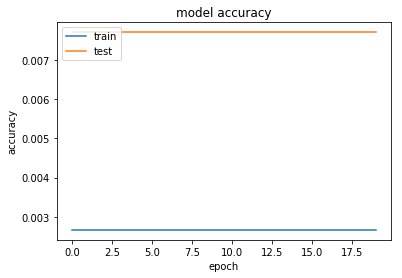

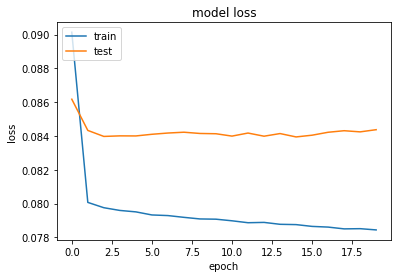

In [29]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train Score: 181.69 RMSE
Test Score: 196.96 RMSE


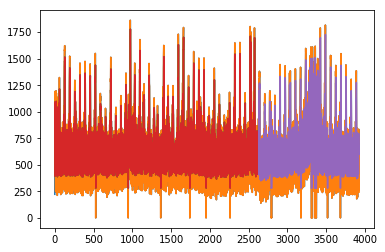

In [30]:

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)-2:len(dataset)+10, 0:1] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

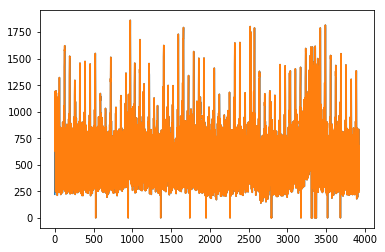

In [31]:
plt.plot(scaler.inverse_transform(dataset))
plt.show()